In [1]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
import time

import pandas as pd
import numpy as np
import matplotlib.pylab as plt

%pylab inline

Populating the interactive namespace from numpy and matplotlib


/Applications/anaconda/envs/stats/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


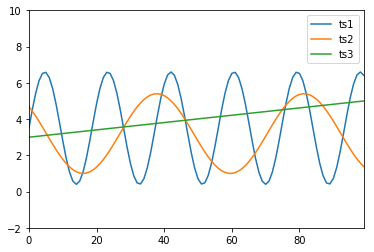

In [2]:
# from http://alexminnaar.com/time-series-classification-and-clustering-with-python.html
x=np.linspace(0,50,100)
ts1=pd.Series(3.1*np.sin(x/1.5)+3.5)
ts2=pd.Series(2.2*np.sin(x/3.5+2.4)+3.2)
ts3=pd.Series(0.04*x+3.0)

ts1.plot()
ts2.plot()
ts3.plot()

plt.ylim(-2,10)
plt.legend(['ts1','ts2','ts3'])
plt.show()

In [3]:
def euclid_dist(t1,t2):
    return np.sqrt(sum((t1-t2)**2))

In [4]:
print(euclid_dist(ts1,ts2))

26.959216038


In [5]:
print(euclid_dist(ts1,ts3))

23.1892491903


In [6]:
# from http://alexminnaar.com/time-series-classification-and-clustering-with-python.html
#DTW: Dynamic Time Warping

def DTWDistance(s1, s2):
    DTW={}
    
    for i in range(len(s1)):
        DTW[(i, -1)] = float('inf')
    for i in range(len(s2)):
        DTW[(-1, i)] = float('inf')
    DTW[(-1, -1)] = 0

    for i in range(len(s1)):
        for j in range(len(s2)):
            dist= (s1[i]-s2[j])**2
            DTW[(i, j)] = dist + min(DTW[(i-1, j)],DTW[(i, j-1)], DTW[(i-1, j-1)])

    return np.sqrt(DTW[len(s1)-1, len(s2)-1])

In [7]:
print(DTWDistance(ts1,ts2))
print(DTWDistance(ts1,ts3))

17.9297184686
21.5494948244


In [8]:
# from http://alexminnaar.com/time-series-classification-and-clustering-with-python.html
def DTWDistance(s1, s2,w):
    DTW={}
    
    w = max(w, abs(len(s1)-len(s2)))
    
    for i in range(-1,len(s1)):
        for j in range(-1,len(s2)):
            DTW[(i, j)] = float('inf')
    DTW[(-1, -1)] = 0
  
    for i in range(len(s1)):
        for j in range(max(0, i-w), min(len(s2), i+w)):
            dist= (s1[i]-s2[j])**2
            DTW[(i, j)] = dist + min(DTW[(i-1, j)],DTW[(i, j-1)], DTW[(i-1, j-1)])
		
    return np.sqrt(DTW[len(s1)-1, len(s2)-1])

In [9]:
print(DTWDistance(ts1,ts2,10))
print(DTWDistance(ts1,ts3,10))

18.5965518384
22.4724828468


In [10]:
# from http://alexminnaar.com/time-series-classification-and-clustering-with-python.html
def LB_Keogh(s1,s2,r):
    LB_sum=0
    for ind,i in enumerate(s1):
        
        lower_bound=min(s2[(ind-r if ind-r>=0 else 0):(ind+r)])
        upper_bound=max(s2[(ind-r if ind-r>=0 else 0):(ind+r)])
        
        if i>upper_bound:
            LB_sum=LB_sum+(i-upper_bound)**2
        elif i<lower_bound:
            LB_sum=LB_sum+(i-lower_bound)**2
    
    return np.sqrt(LB_sum)

In [11]:
print(LB_Keogh(ts1,ts2,20))
print(LB_Keogh(ts1,ts3,20))

6.25389235159
19.9595478694


In [12]:
# 1-NN KNN from paper using LB-KEOGH metric
def knn(train,test,w):
    preds=[]
    for ind,i in enumerate(test):
        min_dist=float('inf')
        closest_seq=[]
        #print ind
        for j in train:
            if LB_Keogh(i[:-1],j[:-1],w)<min_dist:
                dist=DTWDistance(i[:-1],j[:-1],w)
                if dist<min_dist:
                    min_dist=dist
                    closest_seq=j
        preds.append(closest_seq[-1])
    return preds

In [13]:
def print_metrics(y_true, y_pred, label):
    print(label)
    print(f"Accuracy: %.2f" %accuracy_score(y_true, y_pred))
    print(classification_report(y_true, y_pred))

In [14]:
train_act = np.genfromtxt('datasets/train_act.csv', delimiter=',')
test_act = np.genfromtxt('datasets/test_act.csv', delimiter=',')

In [15]:
y_train = train_act[:,-1]
x_train = train_act[:,:-1]
y_test = test_act[:,-1]
x_test = test_act[:,:-1]
y_train.shape, x_train.shape, y_test.shape, x_test.shape

((68,), (68, 500), (37,), (37, 500))

In [16]:
s = time.time()
TS_class_pred = knn(train_act,test_act,4)
e = time.time()
print_metrics(y_test,TS_class_pred, label='1-KNN Time Series')
e-s

1-KNN Time Series
Accuracy: 0.73
             precision    recall  f1-score   support

        2.0       0.85      0.71      0.77        24
        3.0       0.59      0.77      0.67        13

avg / total       0.76      0.73      0.74        37



57.540204763412476

In [17]:
#Baseline KNN

In [18]:
neigh = KNeighborsClassifier(n_neighbors=1)
neigh.fit(x_train,y_train) 
base_y_pred = neigh.predict(x_test) 

In [19]:
print_metrics(y_test, base_y_pred, label= 'Baseline 1-KNN')

Baseline 1-KNN
Accuracy: 0.70
             precision    recall  f1-score   support

        2.0       0.81      0.71      0.76        24
        3.0       0.56      0.69      0.62        13

avg / total       0.72      0.70      0.71        37



In [20]:
# vary window

In [21]:
for w in range(1,3):
    s = time.time()
    TS_class_pred = knn(train_act,test_act,w)
    e = time.time()
    print_metrics(y_test,TS_class_pred, label='1-KNN TS Window '+str(w))
    print("runtime:",e-s)

1-KNN TS Window 1
Accuracy: 0.73
             precision    recall  f1-score   support

        2.0       0.85      0.71      0.77        24
        3.0       0.59      0.77      0.67        13

avg / total       0.76      0.73      0.74        37

runtime: 39.55910778045654
1-KNN TS Window 2
Accuracy: 0.73
             precision    recall  f1-score   support

        2.0       0.85      0.71      0.77        24
        3.0       0.59      0.77      0.67        13

avg / total       0.76      0.73      0.74        37

runtime: 43.4252290725708


In [22]:
for w in range(3,11):
    s = time.time()
    TS_class_pred = knn(train_act,test_act,w)
    e = time.time()
    print_metrics(y_test,TS_class_pred, label='1-KNN TS Window '+str(w))
    print("runtime:",e-s)

1-KNN TS Window 3
Accuracy: 0.73
             precision    recall  f1-score   support

        2.0       0.85      0.71      0.77        24
        3.0       0.59      0.77      0.67        13

avg / total       0.76      0.73      0.74        37

runtime: 44.383235931396484
1-KNN TS Window 4
Accuracy: 0.73
             precision    recall  f1-score   support

        2.0       0.85      0.71      0.77        24
        3.0       0.59      0.77      0.67        13

avg / total       0.76      0.73      0.74        37

runtime: 47.5520179271698
1-KNN TS Window 5
Accuracy: 0.73
             precision    recall  f1-score   support

        2.0       0.85      0.71      0.77        24
        3.0       0.59      0.77      0.67        13

avg / total       0.76      0.73      0.74        37

runtime: 47.02941703796387
1-KNN TS Window 6
Accuracy: 0.73
             precision    recall  f1-score   support

        2.0       0.85      0.71      0.77        24
        3.0       0.59      0.77   

In [23]:
#using SKLearn implementation, but with LB_Keogh metric



In [24]:
neigh_L=KNeighborsClassifier(n_neighbors=1, metric=LB_Keogh, metric_params={"r":2})
neigh_L.fit(x_train,y_train) 
neigh_L_pred = neigh_L.predict(x_test) 

In [25]:
print_metrics(y_test,neigh_L_pred,label= '1-KNN using LB_Keough')

1-KNN using LB_Keough
Accuracy: 0.73
             precision    recall  f1-score   support

        2.0       0.85      0.71      0.77        24
        3.0       0.59      0.77      0.67        13

avg / total       0.76      0.73      0.74        37



In [26]:
#BEST MODEL!

neigh_L=KNeighborsClassifier(n_neighbors=2, metric=LB_Keogh, metric_params={"r":2})
neigh_L.fit(x_train,y_train) 
neigh_L_pred = neigh_L.predict(x_test) 

print_metrics(y_test,neigh_L_pred,label= '2-KNN using LB_Keough')

2-KNN using LB_Keough
Accuracy: 0.76
             precision    recall  f1-score   support

        2.0       0.76      0.92      0.83        24
        3.0       0.75      0.46      0.57        13

avg / total       0.76      0.76      0.74        37



In [27]:
neigh_L=KNeighborsClassifier(n_neighbors=2, metric=LB_Keogh, metric_params={"r":5})
neigh_L.fit(x_train,y_train) 
neigh_L_pred = neigh_L.predict(x_test) 

print_metrics(y_test,neigh_L_pred,label= '2-KNN using LB_Keough window 5')

2-KNN using LB_Keough window 5
Accuracy: 0.76
             precision    recall  f1-score   support

        2.0       0.78      0.88      0.82        24
        3.0       0.70      0.54      0.61        13

avg / total       0.75      0.76      0.75        37



In [28]:
neigh_L=KNeighborsClassifier(n_neighbors=1, metric=LB_Keogh, metric_params={"r":100})
neigh_L.fit(x_train,y_train) 
neigh_L_pred = neigh_L.predict(x_test) 

print_metrics(y_test,neigh_L_pred,label= '1-KNN using LB_Keough')

1-KNN using LB_Keough
Accuracy: 0.59
             precision    recall  f1-score   support

        2.0       0.80      0.50      0.62        24
        3.0       0.45      0.77      0.57        13

avg / total       0.68      0.59      0.60        37



In [29]:
neigh_L_train = neigh.predict(x_train) 

print_metrics(y_train,neigh_L_train,label= '1-KNN using LB train')

1-KNN using LB train
Accuracy: 1.00
             precision    recall  f1-score   support

        2.0       1.00      1.00      1.00        39
        3.0       1.00      1.00      1.00        29

avg / total       1.00      1.00      1.00        68



In [30]:
neigh2 = KNeighborsClassifier(n_neighbors=2)
neigh2.fit(x_train,y_train) 
base_y_pred2 = neigh2.predict(x_test) 
print_metrics(y_test,base_y_pred2,label= '2-KNN')

2-KNN
Accuracy: 0.73
             precision    recall  f1-score   support

        2.0       0.75      0.88      0.81        24
        3.0       0.67      0.46      0.55        13

avg / total       0.72      0.73      0.72        37



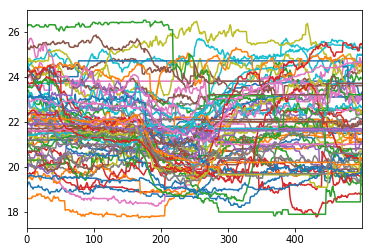

In [31]:
for i in range(0,len(x_train)):
    pd.Series(x_train[i]).plot();

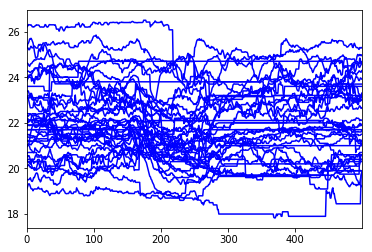

In [32]:
for i in range(0,len(x_train)):
    if y_train[i]==2:
        pd.Series(x_train[i]).plot(c='b');

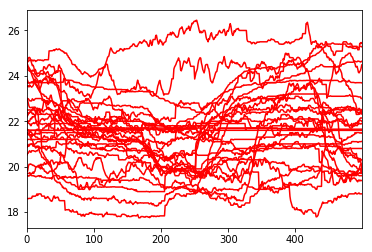

In [33]:
for i in range(0,len(x_train)):
    if y_train[i]==3:
        pd.Series(x_train[i]).plot(c='r');

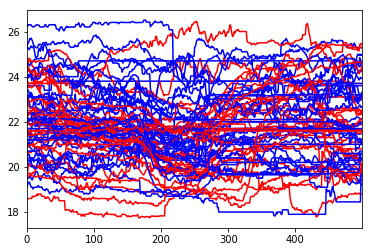

In [41]:
#Train
for i in range(0,len(x_train)):
    if y_train[i]==2:
        pd.Series(x_train[i]).plot(c='b', label = '2');
    if y_train[i]==3:
        pd.Series(x_train[i]).plot(c='r', label = '3');


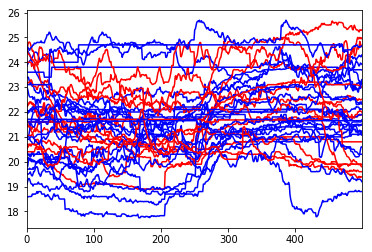

In [35]:
#Test
for i in range(0,len(x_test)):
    if y_test[i]==2:
        pd.Series(x_train[i]).plot(c='b');
    else:
        pd.Series(x_train[i]).plot(c='r');

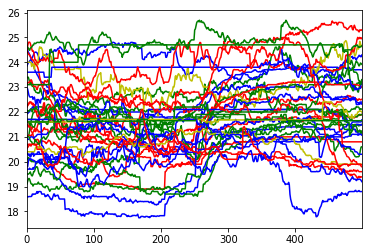

In [38]:
#Test
for i in range(0,len(x_test)):
    if y_test[i]==2:
        if neigh_L_pred[i]==2:
            pd.Series(x_train[i]).plot(c='b', label = '2-2');
        else:
            pd.Series(x_train[i]).plot(c='g', label = '2-3');
    else:
        if neigh_L_pred[i]==3:
            pd.Series(x_train[i]).plot(c='r', label = '3-3');
        else:
            pd.Series(x_train[i]).plot(c='y', label = '3-2');

